In [386]:
import numpy as np
from matplotlib import pyplot as plt

In [387]:
!curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz
!tar -x -z -f /tmp/data.tar.gz
!rm -f /tmp/data.tar.gz

In [521]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [522]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


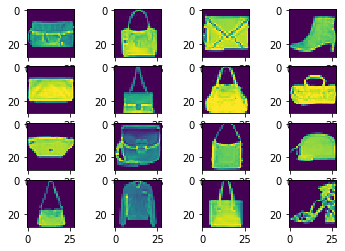

In [523]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

## 5.1 Implementing "vanilla" perceptron.

In [524]:
# function to create weight and bias parameters for the algorithm
def initialise_parameters(xs):
    w = np.zeros((xs.shape[1], xs.shape[2]))
    b = 0
    return w, b

In [652]:
# function to train baseline model
def train_vanilla_perceptron(xs, ys, devxs, devys):
    w, b = initialise_parameters(xs)
    
    # store validation set accuracy and consecutive epochs count to detect convergence
    accuracy_old = accuracy(devxs, devys, w, b)
    row_epoch = 0

    epoch = 0
            
    # train model
    while True:
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        print('Epoch', epoch)
        for i in range (xs.shape[0]):
            y_hat = predict_vanilla(w, b, trainxs_shuffled[i])
            if y_hat != trainys_shuffled[i]:
                if trainys_shuffled[i] == 1:
                    w += trainxs_shuffled[i]
                    b += 1
                else:
                    w -= trainxs_shuffled[i]
                    b -= 1
                    
        # check for convergence
        validation_accuracy = accuracy(devxs, devys, w, b)
        print('validation set accuracy', validation_accuracy)
        if np.abs(validation_accuracy - accuracy_old) < 0.2 and validation_accuracy > 97:
            row_epoch += 1
            if row_epoch == 1:
                break
        else:
            row_epoch = 0
        accuracy_old = validation_accuracy
        epoch += 1
    return w, b

In [653]:
# function to make predictions
def predict_vanilla(w, b, x):
    if np.matmul(w.flatten(), x.flatten()) + b >= 0:
        return 1
    return 0

In [654]:
def predict_vanilla_raw(w, b, x):
    return np.matmul(w.flatten(), x.flatten()) + b

In [655]:
# # # sigmoid for a single sample
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

In [656]:
# function to determine validation loss
def accuracy(devxs, devys, w, b):
    accuracy = 0
    for i in range (devxs.shape[0]):
        yp = predict_vanilla(w, b, devxs[i])
        if (yp == devys[i]):
            accuracy += 1
    return accuracy / devys.shape[0] * 100

In [657]:
# function to determine validation loss
def validation_loss(devxs, devys, w, b):
    l = 0
    for i in range (devxs.shape[0]):
        yprime = predict_vanilla_raw(w, b, devxs[i])
        if (yprime == 0 and devys[i] == 1):
            yprime += 1e-15
        elif yprime == 1 and devys[i] == 0:
            yprime -= 1e-15
        if devys[i] == 1:
            l += np.log(yprime)
        else:
            l += np.log(1 - yprime)
    return ((-1) / devys.shape[0]) * l

## 5.2 Train baseline model

Out of the observed values (multiple runs for first 200 epochs), the best accuracy on validation set that we observed  was around 97.5. Based on this, we decided to stop training when accuracy remained above 97% on two consecutive epochs, and the difference betweent accuracies is at most 0.1.

In [658]:
w_train, b_train = train_vanilla_perceptron(trainxs, trainys, devxs, devys)
dev_accuracy = accuracy(devxs, devys, w_train, b_train)
# dev_loss = validation_loss(devxs, devys, w_train, b_train)
print('Vanilla Perceptron final validation accuracy:', dev_accuracy)
# print('Vanilla Perceptron final validation loss:', dev_loss)

Epoch 0
validation set accuracy 90.0
Epoch 1
validation set accuracy 98.1
Epoch 2
validation set accuracy 82.0
Epoch 3
validation set accuracy 83.8
Epoch 4
validation set accuracy 97.3
Epoch 5
validation set accuracy 96.7
Epoch 6
validation set accuracy 79.4
Epoch 7
validation set accuracy 89.1
Epoch 8
validation set accuracy 95.6
Epoch 9
validation set accuracy 97.2
Epoch 10
validation set accuracy 97.6
Epoch 11
validation set accuracy 97.0
Epoch 12
validation set accuracy 97.3
Epoch 13
validation set accuracy 97.39999999999999
Vanilla Perceptron final validation accuracy: 97.39999999999999


## 5.3 Outperforming Vanilla Perceptron

Use 3 layer mlp stochastic gradient descent with 0.9 momentum cause why not.

In [661]:
# sigmoid for a single sample, preventing overflow
def sigmoid(z):
    return np.exp(np.fmin(z, 0)) / (1 + np.exp(-np.abs(z)))
# sigmoid derivative
def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [662]:
# forward pass
def forward(params, x):
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["W2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    forward_res["z3"] = params["W3"] @ forward_res["a2"] + params["b3"]
    forward_res["a3"] = sigmoid(forward_res["z3"])
    
    return forward_res

In [663]:
# idk what those are and at this point i'm too scared to ask
def loss(y_pred, y):
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

def loss_prime(y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [680]:
# backpropagation
def backprop(x, y, params, forward_res):
    x = x.reshape(28**2, 1)
    
    grads = {}
    
    z1 = params["W1"].dot(x) + params["b1"]
    a1 = sigmoid(z1)
    
    z2 = params["W2"].dot(a1) + params["b2"]
    a2 = sigmoid(z2)
    
    z3 = params["W3"].dot(a2) + params["b3"]
    y_pred = a3 = sigmoid(z3)
    
    dL_dz3 = loss_prime(y_pred, y) * sigmoid_d(z3) # (1, 1)
    dL_dz2 = dL_dz3.dot(params["W3"]).T * sigmoid_d(z2) # (20, 1)
    dL_dz1 = np.multiply(dL_dz2.T.dot(params["W2"]).T, sigmoid_d(z1)) # (200, 1)
    
    grads["dW3"] = dL_dz3.dot(a2.T) # (1, 20) <- not sure those are right didn't check
    grads["db3"] = dL_dz3 # (1, 1)
    
    grads["dW2"] = dL_dz2.dot(a1.T) # (20, 200)
    grads["db2"] = dL_dz2 # (20, 1)
    
    grads["dW1"] = dL_dz1.dot(x.T) # (784, 200)
    grads["db1"] = dL_dz1 # (200, 1)

    return grads

In [682]:
# function to calculate accuracy
def accuracy(devxs, devys, params):
    accuracy = 0
    for i in range (devxs.shape[0]):
        yp = predict_mlp(devxs[i], params)
        if (yp == devys[i]):
            accuracy += 1
    return (accuracy / devys.shape[0]) * 100

In [683]:
def predict_mlp(x, params):    
    forward_res = forward(params, x)
    if forward_res["a3"] >= 0.5:
        return 1
    return 0

In [701]:
def update_params(grads, params, lr, momentum, dW1, db1, dW2, db2, dW3, db3):
#     I DO NOT KNOW WHAT THIS IS
# THIS IS WITH MOMENTUM BUT I DONT THINK WE NEED IT UWU
    # with momentum (optional)
#     if epoch == 0:
#                dW1 = 0
#                db1 = 0
#                ...
    # use momentum 0 so dW1 = grads["dW1"], db1 = grads["db1"]...
    dW1 = momentum * dW1 + (1 - momentum) * grads["dW1"]
    db1 = momentum * db1 + (1 - momentum) * grads["db1"]
    dW2 = momentum * dW2 + (1 - momentum) * grads["dW2"]
    db2 = momentum * db2 + (1 - momentum) * grads["db2"]
    dW3 = momentum * dW3 + (1 - momentum) * grads["dW3"]
    db3 = momentum * db3 + (1 - momentum) * grads["db3"]

    params["W1"] -= (lr * dW1)
    params["b1"] -= lr * db1
    params["W2"] -= (lr * dW2)
    params["b2"] -= lr * db2
    params["W3"] -= (lr * dW3)
    params["b3"] -= lr * db3
    return params

In [702]:
def update_grads(grads, ups, batch_size):
    grads["dW3"] -= ups["dW3"] / batch_size
    grads["db3"] -= ups["db3"] / batch_size
    
    grads["dW2"] -= ups["dW2"] / batch_size
    grads["db2"] -= ups["db3"] / batch_size
    
    grads["dW1"] -= ups["dW1"] / batch_size
    grads["db1"] -= ups["db1"] / batch_size
    return grads

In [703]:
# CORRECT function to determine loss
def validation_loss_c(devxs, devys, params):
    l = 0
    for i in range (devxs.shape[0]):
        yprime = predict_raw(devxs[i], params)
        if (yprime == 0 and devys[i] == 1):
            yprime += 1e-15
        elif yprime == 1 and devys[i] == 0:
            yprime -= 1e-15
        if devys[i] == 1:
            l += np.log(yprime)
        else:
            l += np.log(1 - yprime)
    return ((-1) / devys.shape[0]) * l

In [704]:
from sklearn.metrics import log_loss

In [705]:
def predict_raw(x, params):
    forward_res = forward(params, x)
    
    return forward_res["a3"][0, 0]

In [833]:
def mlp(xs, ys, learning_rate, momentum, devxs, devys):
    img_size = 28**2
    h1 = 200
    h2 = 20
    out_size = 1
    
    #     stores training set loss for part 3.5
    loss_training = []
    loss_validation = []
    
    #     stores training set accuracy for part 3.6
    accuracy_training = []
    
    #     stores validation set accuracy for part 3.7
    accuracy_validation = []
    
    # initialise parameters
    params = {"W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h1, 1)),
              "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
              "b2": np.zeros((h2, 1)),
              "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
              "b3": np.zeros((out_size, 1))}
    grads = {}
    
    loss_old = validation_loss_c(devxs, devys, params)
    
    epoch = 0
    
    while True:
        # shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        
        grads["dW3"]  = np.zeros_like(params["W3"])
        grads["db3"] = np.zeros_like(params["b3"])

        grads["dW2"] = np.zeros_like(params["W2"])
        grads["db2"] = np.zeros_like(params["b2"])

        grads["dW1"] = np.zeros_like(params["W1"])
        grads["db1"] = np.zeros_like(params["b1"])
        
        if epoch == 0:
            dW1 = np.zeros_like(params["W1"])
            db1 = np.zeros_like(params["b1"])
            
            dW2 = np.zeros_like(params["W2"])
            db2 = np.zeros_like(params["b2"])
            
            dW3 = np.zeros_like(params["W3"])
            db3 = np.zeros_like(params["b3"])
        
        print("epoch", epoch)
        for i in range (trainxs.shape[0]):
            forward_res = forward(params, trainxs_shuffled[i])
            grads = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
            params = update_params(grads, params, learning_rate, momentum, dW1, db1, dW2, db2, dW3, db3)
#         update lists storing accuracy and loss values
        loss_t = validation_loss_c(xs, ys, params)
        loss_training.append(loss_t)
        
        accuracy_t = accuracy(xs, ys, params)
        accuracy_training.append(accuracy_t)
    
        accuracy_valid = accuracy(devxs, devys, params)
        accuracy_validation.append(accuracy_valid)
        
        loss_valid = validation_loss_c(devxs, devys, params)
        loss_validation.append(loss_valid)
        print('validation loss', loss_valid)
        print('want', log_loss(devys, [predict_raw(x, params) for x in devxs]))
        print('training loss', loss_t)
        print('validation accuracy', accuracy_valid)
        print('training accuracy', accuracy_t)
        
        if np.abs(loss_valid - loss_old) == 0:
            row_epoch += 1
            if row_epoch == 3:
                break
        else:
            row_epoch = 0
        loss_old = loss_valid
        epoch += 1
        if epoch == 300:
            break
    return epoch, loss_training, accuracy_training, accuracy_validation, loss_validation

In [834]:
# full-batch gradient descent, so not using batch_size as a parameter
learning_rate = 0.001
momentum = 0.4

In [835]:
epoch, loss_training, accuracy_training, accuracy_validation, loss_validation = mlp(trainxs, trainys, learning_rate, momentum, devxs, devys)

epoch 0
validation loss 0.636005077920826
want 0.6360050779208263
training loss 0.6377979259055712
validation accuracy 79.5
training accuracy 79.21666666666667
epoch 1
validation loss 0.5188182312912739
want 0.5188182312912734
training loss 0.5228279362817886
validation accuracy 85.39999999999999
training accuracy 85.625
epoch 2
validation loss 0.3666938655266899
want 0.3666938655266895
training loss 0.37560846137419857
validation accuracy 89.8
training accuracy 88.925
epoch 3
validation loss 0.2568553408622104
want 0.2568553408622105
training loss 0.27134142068168066
validation accuracy 92.80000000000001
training accuracy 92.05833333333334
epoch 4
validation loss 0.19107242396686805
want 0.19107242396686824
training loss 0.20680816488506434
validation accuracy 95.39999999999999
training accuracy 94.44166666666666
epoch 5
validation loss 0.15811855094283944
want 0.15811855094283941
training loss 0.17399165637258157
validation accuracy 95.89999999999999
training accuracy 95.108333333333

## 5.4 Motivation and Final Model

The next logical step in an attempt to increase the model's accuracy is introducing hidden layers to the model. We attempted to create a model with two and three hidden layes and different hyper parameters, and observed how it affects the output loss and accuracy of the model.

## 5.5 Loss plot for best model

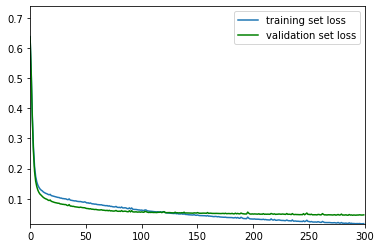

In [836]:
plt.axis([0, epoch, min(min(loss_training), min(loss_validation)), max(max(loss_training), max(loss_validation)) + 0.1])
plt.plot(loss_training, label='training set loss')
plt.plot(loss_validation, color='green', label="validation set loss")
plt.legend(loc='upper right')

## 5.6 Accuracy plot for best model

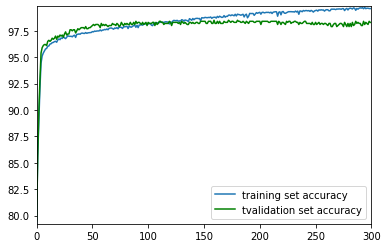

In [837]:
plt.axis([0, epoch, min(min(accuracy_training), min(accuracy_validation)), max(max(accuracy_training), max(accuracy_validation)) + 0.1])
plt.plot(accuracy_training, label='training set accuracy')
plt.plot(accuracy_validation, color='green', label="tvalidation set accuracy")
plt.legend(loc='lower right')

## 5.7 Accuracy on best epoch

In [838]:
ind = accuracy_validation.index(max(accuracy_validation))

In [839]:
print("Best epoch =", ind)
print("Accuracy on training set =", accuracy_training[ind])
print("Accuracy on validation set =", accuracy_validation[ind])

Best epoch = 159
Accuracy on training set = 98.775
Accuracy on validation set = 98.5


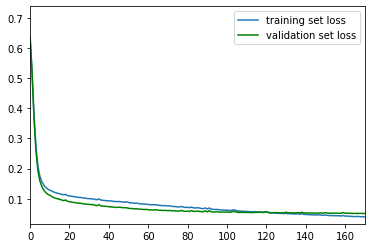

In [845]:
plt.axis([0, epoch-130, min(min(loss_training), min(loss_validation)), max(max(loss_training), max(loss_validation)) + 0.1])
plt.plot(loss_training, label='training set loss')
plt.plot(loss_validation, color='green', label="validation set loss")
plt.legend(loc='upper right')

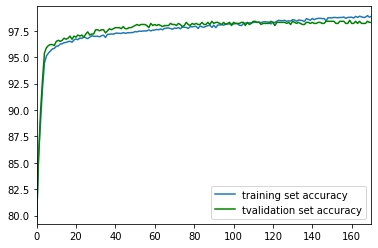

In [846]:
plt.axis([0, epoch-130, min(min(accuracy_training), min(accuracy_validation)), max(max(accuracy_training), max(accuracy_validation)) + 0.1])
plt.plot(accuracy_training, label='training set accuracy')
plt.plot(accuracy_validation, color='green', label="tvalidation set accuracy")
plt.legend(loc='lower right')